# Quick comparison of "Linear Combination" to "UV combination" #

This is a quick script to compare the 'linear combination' approach to the feathering/UV combination approach for a synthetic data set.  The code is fairly messy because the underlying functions are designed to run on FITS files, not on arrays, so I had to cut and past pieces.

In [1]:
# ipython notebook setup:
%matplotlib inline

In [2]:
import pylab as pl
pl.rcParams['image.interpolation'] = 'nearest'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (12,8)
pl.rcParams['image.cmap'] = 'viridis'
pl.rcParams['patch.edgecolor'] = 'none'
pl.rcParams['axes.prop_cycle'] = pl.cycler('color', ('#338ADD', '#9A44B6', '#A60628', '#467821', '#CF4457', '#188487', '#E24A33'))

In [3]:
import image_registration
from astropy import convolution
import numpy as np
from uvcombine.uvcombine import feather_kernel, fftmerge, linear_combine, feather_simple

In [4]:
# create an input image with specified parameters
# (this can later be modified - it will be good to examine the effects of
# different power laws, different types of input...)
# We're assuming a scale of 1"/pixel for this example
np.random.seed(0)
imsize = 512
im = image_registration.tests.make_extended(imsize=imsize, powerlaw=1.5)

In [5]:
ygrid, xgrid = np.indices(im.shape, dtype='float')
rr = ((xgrid-im.shape[1]/2)**2+(ygrid-im.shape[0]/2)**2)**0.5

In [6]:
# Create a UV sampling mask.
# This removes all large-angular scale (r<8) features *in UV space* and all
# small angular scales.
# In fourier space, r=0 corresponds to the DC component
# r=1 corresponds to the full map (one period over that map)
# r=256 is the smallest angular scale, which is 2 pixels (nyquist sampling....?)
# We're assuming a pixel scale of 1" / pixel
# therefore 56" corresponds to 9m at 2mm (i.e., nearly the closest spacing possible for 7m)
# We cut off the "interferometer" at 2.5" resolution
largest_scale = 56.
smallest_scale = 2.5
image_scale = im.shape[0] # assume symmetric (default=256)
ring = (rr>=(image_scale/largest_scale)) & (rr<=(image_scale/smallest_scale))

In [7]:
# create the interferometric map by removing both large and small angular
# scales in fourier space
imfft = np.fft.fft2(im)
imfft_interferometered = imfft * np.fft.fftshift(ring)
im_interferometered = np.fft.ifft2(imfft_interferometered)

In [8]:
# create the single-dish map by convolving the image with a FWHM=40" kernel
# (this interpretation is much easier than the sharp-edged stuff in fourier
# space because the kernel is created in real space)
lowresfwhm = 40
singledish_im = convolution.convolve_fft(im,
                                         convolution.Gaussian2DKernel(lowresfwhm/2.35),
                                         boundary='fill', fill_value=im.mean())

In [9]:
# pixel scale can be interpreted as "arcseconds"
# then, fwhm=40 means a beam fwhm of 40"
pixscale = 1
lowresfwhm = 40
nax1,nax2 = im.shape
kfft, ikfft = feather_kernel(nax2, nax1, lowresfwhm, pixscale,)

In [10]:
# Feather the interferometer and single dish data back together
# This uses the naive assumptions that CASA uses
# However, there are a few flags that can be played with.
# None of them do a whole lot, though there are good theoretical
# reasons to attempt them.
im_hi = im_interferometered.real
im_low = singledish_im
lowresscalefactor=1
replace_hires = False
highpassfilterSD = False
deconvSD = False
highresscalefactor=1
fftsum, combo = fftmerge(kfft, ikfft, im_hi*highresscalefactor,
                         im_low*lowresscalefactor,
                         replace_hires=replace_hires,
                         highpassfilterSD=highpassfilterSD,
                         deconvSD=deconvSD,
                        )

In [11]:
from astropy import units as u
import radio_beam
from astropy.convolution import convolve_fft, convolve
#lincombim = linear_combine(im_interferometered, im_low)
im_hi = im_interferometered
pixscale = 1*u.arcsec
beam_low = radio_beam.Beam(40*u.arcsec)

missing_flux = im_low - convolve_fft(im_hi, beam_low.as_kernel(pixscale))

lincombim = missing_flux + im_hi


/Users/adam/anaconda/envs/astropy35/lib/python3.5/site-packages/radio_beam/beam.py:566: UserWarning: as_kernel is not aware of any misaligment  between pixel and world coordinates
  warnings.warn("as_kernel is not aware of any misaligment "


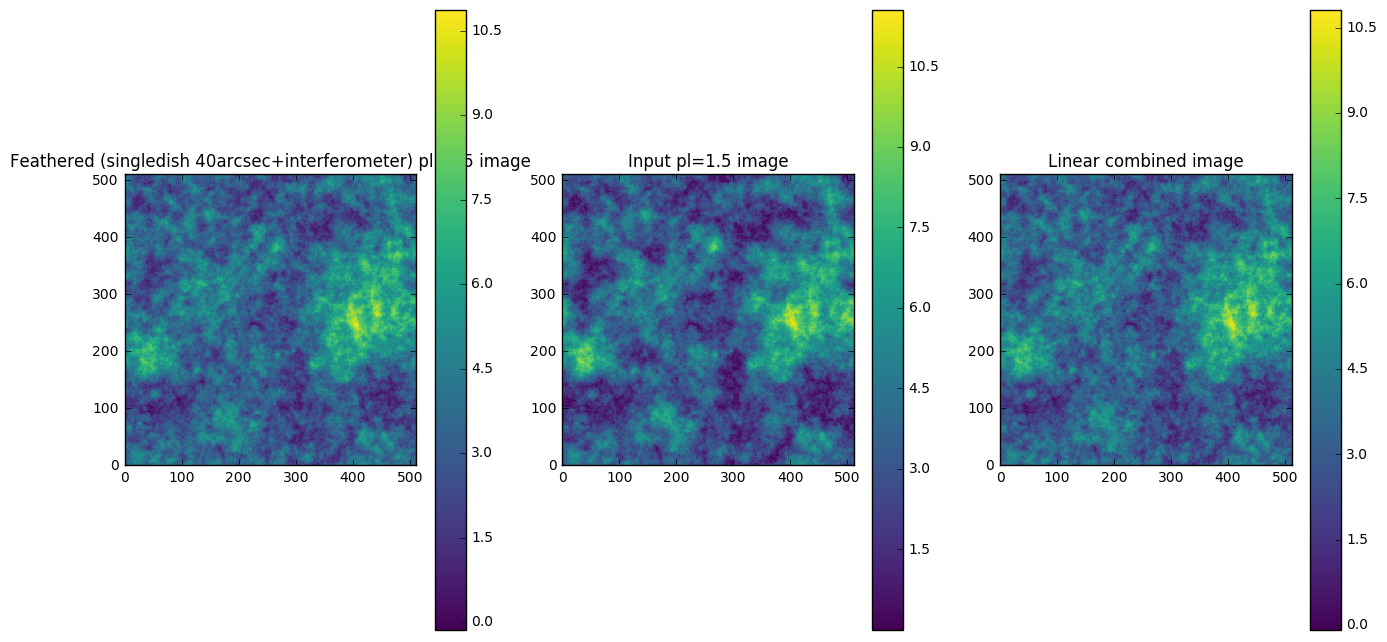

In [12]:
# Feathered dataset
pl.figure(1, figsize=(16,8)).clf()
pl.subplot(1,3,1)
pl.imshow(combo.real, cmap='viridis')
pl.colorbar()
pl.title("Feathered (singledish 40arcsec+interferometer) pl=1.5 image")
pl.subplot(1,3,2)
pl.imshow(im, cmap='viridis')
pl.colorbar()
pl.title("Input pl=1.5 image")
pl.subplot(1,3,3)
pl.imshow(lincombim.real, cmap='viridis')
pl.colorbar()
pl.title("Linear combined image")

It looks like feathering & linear combination have very similar results, as you might expect.

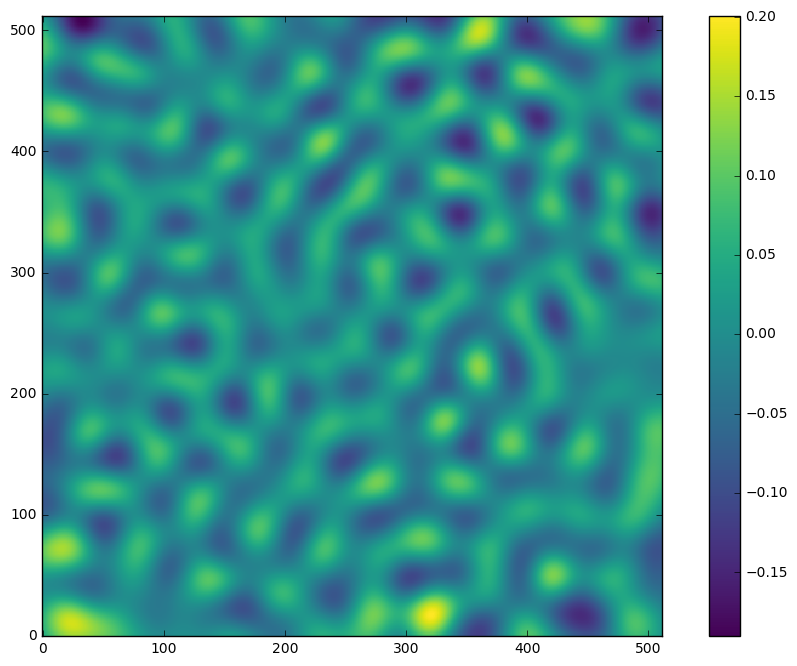

In [13]:
pl.imshow(combo.real-lincombim.real, cmap='viridis')
pl.colorbar()